# DivExplorer: Finding Divergent Data Subgroups

 <a href="https://colab.research.google.com/github/divexplorer/divexplorer/blob/main/notebooks/DivExplorerExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DivExplorer will find data subgroups that are _divergent_, that is, subgroups that have a different value for a target statistics than the rest of the data. For example, in a dataset of loan applicants, DivExplorer can find subgroups that have a different loan approval rate than the rest of the data.

In the simplest case, the target statistics is the average of some numerical field, and DivExplorer will find subgroups that have highest or lowest average for that field. 

We need to install the DivExplorer package and import it. You can comment out the installation line if you have it already installed. 

In [1]:
%pip install divexplorer


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from divexplorer import DivergenceExplorer, DivergencePatternProcessor

## A census example

### An example of a quantitative outcome analysis

As a simple example, we apply DivExplorer to a dataset derived from [census data](https://www.census.gov/data/datasets/time-series/demo/cps/cps-asec.html). 
The dataset contains state of residence, gender, educational achievement, age, and income, and we will find subgroups with lowest and highest average income. 
The income is our _quantitative outcome_: it is the variable whose average we want to compare between subgroups. 

In [3]:
import pandas as pd

df_census = pd.read_csv('https://raw.githubusercontent.com/divexplorer/divexplorer/main/datasets/census_income.csv')
df_census.head()

,STATE,SEX,EDUCATION,A_AGE,PTOTVAL
0,maine,Female,High school,66,12120
1,maine,Female,High school,68,16800
2,maine,Female,High school,52,8137
3,maine,Male,Some college but no degree,51,42000
4,maine,Female,High school,78,14713


DivExplorer works on discretized data (we published a [study](https://divexplorer.github.io) on how to discretize datasets, and we will soon extend this code with automatic discretization, but for now you have to provide discretized datasets). 
Using age with one-year resolution may be too fine; let us define an `age_range` column with age discretized in decades. 

In [4]:
df_census["AGE_RANGE"] = df_census.apply(lambda row : 10 * (row["A_AGE"] // 10), axis=1)
df_census.head()

,STATE,SEX,EDUCATION,A_AGE,PTOTVAL,AGE_RANGE
0,maine,Female,High school,66,12120,60
1,maine,Female,High school,68,16800,60
2,maine,Female,High school,52,8137,50
3,maine,Male,Some college but no degree,51,42000,50
4,maine,Female,High school,78,14713,70


Great, let's find those subgroups.  Subgroups search is done via the `DivergenceExplorer` class. 

In [5]:
fp_diver = DivergenceExplorer(df_census)

To find the subgroups, we need to specify: 
* The column whose average is to be minimized or maximized.  We specify this via the `quantitative_outcomes` parameter.  This is a list of column names whose divergence is of interest. 
* The _minimum support_ of the search.  This is specified via the `min_support` parameter, and corresponds to the minimum fraction of dataset that must be contained in any returned subgroup.  
* The attributes we want to use to define subgroups.  We specify this via the `attributes` parameter.  This is a list of column names whose values will be used to define subgroups. If missing, all columns except outcomes are used. 

Specifying a minimum support is useful to bound the search, and to ensure that the returned subgroups are not too small and the divergence is statistically significant.
A minimum support of 0.001 indicates that subgroups must contain at least 0.1% of the dataset.

In [6]:
subgroups = fp_diver.get_pattern_divergence(
    attributes=['SEX', 'EDUCATION', 'AGE_RANGE'],
    min_support=0.001, quantitative_outcomes=["PTOTVAL"])
subgroups = subgroups.sort_values(by="PTOTVAL_div", ascending=False, ignore_index=True)
subgroups.head(10)

,itemset,support,support_count,length,PTOTVAL_count,PTOTVAL,PTOTVAL_div,PTOTVAL_t
0,"(SEX=Male, EDUCATION=Professional, AGE_RANGE=40)",0.001129,165,3,165.0,248210.406061,206751.799469,10.855545
1,"(EDUCATION=Professional, AGE_RANGE=40)",0.002429,355,2,355.0,207456.191549,165997.584958,14.157974
2,"(AGE_RANGE=50, EDUCATION=Professional)",0.001759,257,2,257.0,192899.428016,151440.821424,12.651215
3,"(EDUCATION=Doctorate, SEX=Male, AGE_RANGE=50)",0.001601,234,3,234.0,186660.354701,145201.748110,11.941443
4,"(EDUCATION=Doctorate, SEX=Male, AGE_RANGE=40)",0.001533,224,3,224.0,185358.575893,143899.969302,13.573464
5,"(SEX=Male, EDUCATION=Professional)",0.005413,791,2,791.0,175549.437421,134090.830830,19.951770
6,"(EDUCATION=Doctorate, AGE_RANGE=50)",0.002833,414,2,414.0,168553.306763,127094.700172,15.438620
7,"(SEX=Female, EDUCATION=Professional, AGE_RANGE...",0.001239,181,3,181.0,167925.044199,126466.437608,9.035660
8,"(EDUCATION=Doctorate, AGE_RANGE=40)",0.003250,475,2,475.0,160665.410526,119206.803935,18.356290
9,"(EDUCATION=Doctorate, SEX=Male, AGE_RANGE=30)",0.001615,236,3,236.0,153487.627119,112029.020527,13.050126


Let's look at the columns in the result: 
* The first column is an id that is useful to refer to the subgroup.
* `support` is the fraction of the dataset contained in the subgroup.
* `itemset` is the set of items (set of parameters) defining the subgroup. 
* `PTOTVAL` is the average value of the `PTOTVAL` column in the subgroup, that is, for us, the average income in the subgroup. 
* `PTOTVAL_div` is the difference between the average income in the subgroup and the average income in the dataset.  This is the divergence value, and the column we are interested in.  The larger the divergence value, the more divergent the subgroup.
* `PTOTVAL_t` is the t-statistic of the divergence value.  This is useful to assess the statistical significance of the divergence value.  The larger the t-statistic, the more significant the divergence value.
* `length` is the number of items in the subgroup.
* `support_count` is the number of rows of the original dataframe that belong to the subgroup.

### Redundancy pruning

Often, we get too many subgroups that are too similar.  We would like to "prune" the subgroups, keeping only the items (the attribute=value pairs) that contribute the most divergence.  We can do this via redundancy pruning.  In the following example, if adding an item does not modify (increase or decrease) the divergence value by at least 20,000, we remove it.  

In [7]:
processor = DivergencePatternProcessor(subgroups, "PTOTVAL")
df_pruned = processor.redundancy_pruning(th_redundancy=20000)
df_pruned.head(10)

,support,itemset,length,support_count,PTOTVAL,PTOTVAL_div,PTOTVAL_t
0,0.001129,"(SEX=Male, EDUCATION=Professional, AGE_RANGE=40)",3,165,248210.406061,206751.799469,10.855545
1,0.002429,"(EDUCATION=Professional, AGE_RANGE=40)",2,355,207456.191549,165997.584958,14.157974
2,0.001759,"(AGE_RANGE=50, EDUCATION=Professional)",2,257,192899.428016,151440.821424,12.651215
4,0.001533,"(EDUCATION=Doctorate, SEX=Male, AGE_RANGE=40)",3,224,185358.575893,143899.969302,13.573464
5,0.005413,"(SEX=Male, EDUCATION=Professional)",2,791,175549.437421,134090.830830,19.951770
6,0.002833,"(EDUCATION=Doctorate, AGE_RANGE=50)",2,414,168553.306763,127094.700172,15.438620
7,0.001239,"(SEX=Female, EDUCATION=Professional, AGE_RANGE...",3,181,167925.044199,126466.437608,9.035660
8,0.003250,"(EDUCATION=Doctorate, AGE_RANGE=40)",2,475,160665.410526,119206.803935,18.356290
10,0.010627,(EDUCATION=Professional),1,1553,152547.735351,111089.128760,25.715107
12,0.005680,"(AGE_RANGE=50, EDUCATION=Master, SEX=Male)",3,830,149566.365060,108107.758469,21.397630


### Shapley Values to explain divergence in subgroups

We see that the most divergent subgroup is (EDUCATION=Professional, SEX=Male, AGE_RANGE=40). This subgroup has an average income of 246,323, which is 204,865 higher than the average income in the dataset.  The t-statistic is 11, which indicates extremely high significance. There are 170 instances (people in original census dataset) in this subgroup. 

In [8]:
pattern = subgroups['itemset'].iloc[0]
pattern

frozenset({'AGE_RANGE=40', 'EDUCATION=Professional', 'SEX=Male'})

Once we have identified this pattern, the obvious question is: which of the three factors, age range, education, or sex, contributes mostly to the difference in income?  To answer this question, we compute the [Shapley value](https://en.wikipedia.org/wiki/Shapley_value) of the attributes in the (EDUCATION=Professional, SEX=Male, AGE_RANGE=40) coalition.  We do this via the help of the `DivergencePatternProcessor` class.  The Shapley value is a measure of the contribution of each attribute to the divergence value.  The higher the Shapley value, the more the attribute contributes to the divergence value.  The Shapley value is normalized, so that the sum of the Shapley values of all attributes is the divergence of the whole subgroup.

In [9]:
processor = DivergencePatternProcessor(subgroups, 'PTOTVAL')

We can print the Shapley values... 

In [10]:
processor.shapley_value(pattern)

{frozenset({'SEX=Male'}): 23018.165956315985,
 frozenset({'EDUCATION=Professional'}): 133255.90699293802,
 frozenset({'AGE_RANGE=40'}): 50477.72652009613}

... and we can plot them: 

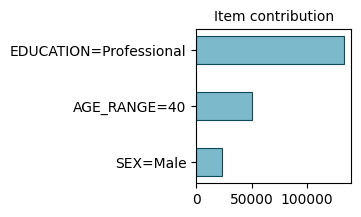

In [11]:
processor.plot_shapley_value(pattern=pattern, figsize=(2,2), title="Item contribution")

As we see, the most important factor is the educational level, followed by age range, followed by sex. 

## Outcomes

When looking for divergence, DivExplorer considers an _outcome_. 
The outcome is a column whose values can be either floating-point numbers, or NaN.
DivExplorer will compute, for each subgroup, the average of all non-NaN values. 

Precisely, if $\alpha$ is the outcome, DivExplorer computes for every subgroup $S$: 

$$
f_\alpha(S) = E[\alpha \mid \alpha \neq NaN]
$$

The divergence of $S$ is then defined by:

$$
\Delta_\alpha(S) = f_\alpha(S) - f_\alpha(D) , 
$$

where $D$ is the whole dataset.


# Divergence in Classifiers

DivExplorer can also be used to analyze the divergence in the performance of classifiers, studying for instance how different subgroups differ in their false positive or false negative rates, accuracy, and so on. 
This yields insights on how the classifier performs on different subgroups, and can be used to detect bias.

## Example: False Positive Rate in COMPAS

As an example, we consider how to find the data subgroups in the  [COMPAS](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) dataset that have greatest divergence in false positive rate.

The COMPAS dataset contains demographic information and the criminal history of defendants. 
The goal is to predict whether defendants will recidivate (commit another crime) in the next two years.
A false positive is a defendant that is predicted to recidivate, but does not.
Subgroups with higher false-positive rate are subgroups that are most disadvantaged by the classifier decisions. 

To identify them, we begin by importing a discretized version of the COMPAS dataset. 

In [12]:

compas_df = pd.read_csv('https://raw.githubusercontent.com/divexplorer/divexplorer/main/datasets/compas_discretized.csv')
compas_df.head()

,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


The COMPAS dataset contains demographic information and the criminal history of defendants.
For each criminal defendant, the following attributes are available:
- `age`: age category of the defendant. 
- `charge`: severity of the charge. 'M'='Misdemeanor','F'='Felony' 
- `race`: 'Afr-Am', 'Asian', 'Cauc', 'Hispanic', 'Native American', 'Other'
- `sex`: 'Female', 'Male'
- `#prior`: number of prior crimes committed by the defendant
- `stay`: length of previous stay in jail. 

For each defendant, the dataset also records:

- the (true) `class`, whether the defendant recidivated (was arrested again) in the next two years. It is 1 if the defendant recidivated, 0 otherwise.
- the `predicted` recidivism, derived from the COMPAS score of recidivism risk. Again, a value of 1 indicates a prediction of recidivism.

### Encoding the false-positive rate as an outcome

To study the false-positive rate, we add an outcome column `fp` whose average yields the false-positive rate, like so: 

In [13]:
from divexplorer.outcomes import get_false_positive_rate_outcome

y_trues = compas_df["class"]
y_preds = compas_df["predicted"]

compas_df['fp'] =  get_false_positive_rate_outcome(y_trues, y_preds)
compas_df[105:110]

,age,charge,race,sex,#prior,stay,class,predicted,fp
105,25-45,F,Afr-Am,Male,"[1,3]",<week,1,1,NaN
106,>45,M,Cauc,Male,"[1,3]",<week,0,1,1.0
107,25-45,F,Afr-Am,Male,>3,<week,1,1,NaN
108,25-45,F,Cauc,Male,>3,<week,0,0,0.0
109,25-45,F,Cauc,Female,"[1,3]",<week,0,0,0.0


The `fp` column has values: 

* 1, if the data is a false positive (`class` is 0 and `predicted` is 1)
* 0, if the data is a true negative (`class` is 0 and `predicted` is 0). 
* NaN, if the class is positive (`class` is 1).

We use NaN values to exclude data from the average, so that the average of the `fp` column is the false-positive rate. 

### Finding divergent subgroups in a classifier

Once this new column is added, we can again ask for divergence.

Note how we specify via `attributes` what are the columns we want to use to form the subgroups, to exclude uninteresting columns such as `class` and `predicted`.

Note also that `fp` is passed as a `boolean_outcomes`.  The difference between quantitative outcomes (such as income in the census example) and boolean outcomes (such as false-positive rate) are treated lies in how the statistical significance is computed. 
In both cases, we use [Welch's t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test), but for boolean outcomes, we use the mean and standard deviation of the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) to compute the t-statistic. See the [papers](https://divexplorer.github.io) for details.

In [14]:
fp_diver = DivergenceExplorer(compas_df)

attributes = ['race', '#prior', 'sex', 'age']
FP_fm = fp_diver.get_pattern_divergence(min_support=0.1, attributes=attributes, 
                                        boolean_outcomes=['fp'])
FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
FP_fm.head(10)

,itemset,support,support_count,length,fp_count,fp,fp_div,fp_t
0,"(#prior=>3, race=Afr-Am, age=25-45)",0.122813,758,3,228.0,0.276316,0.188002,13.683395
1,"(#prior=>3, race=Afr-Am)",0.196695,1214,2,383.0,0.261097,0.172783,15.525674
2,"(#prior=>3, age=25-45)",0.207226,1279,2,397.0,0.251889,0.163575,16.267585
3,"(#prior=>3, sex=Male, race=Afr-Am)",0.146792,906,3,277.0,0.241877,0.153563,14.424100
4,"(#prior=>3, sex=Male, age=25-45)",0.153597,948,3,294.0,0.234694,0.146380,14.387448
5,"(#prior=>3, sex=Male)",0.256643,1584,2,516.0,0.222868,0.134554,16.378453
6,(#prior=>3),0.293422,1811,1,602.0,0.219269,0.130955,16.650191
7,"(age=<25, race=Afr-Am)",0.131076,809,2,318.0,0.207547,0.119233,8.290631
8,"(age=<25, sex=Male)",0.178386,1101,2,440.0,0.188636,0.100322,9.038667
9,(age=<25),0.218244,1347,1,593.0,0.177066,0.088752,7.005075


The subgroup with highest false-positive rate is (sex=Male, age=25-45, race=Afr-Am, #prior=>3), and they have a rate of 30.8%, which is 22% above the average false-positive rate.  The t-statistic is 7.1, which indicates high significance.  There are 794 instances in this subgroup.

#### Shapley Value

The divergence of each pattern can be attributed to the items (_attribute=value_ pairs) that compose it via the Shapley value. 

In [15]:
processor = DivergencePatternProcessor(FP_fm, 'fp')

# We can pick a pattern 
pattern = processor.patterns['itemset'].iloc[0]
print(pattern)

# and compute the Shapley value of the items. 
sv = processor.shapley_value(pattern)
sv

frozenset({'#prior=>3', 'race=Afr-Am', 'age=25-45'})


{frozenset({'#prior=>3'}): 0.13720546525188068,
 frozenset({'race=Afr-Am'}): 0.04033102755330445,
 frozenset({'age=25-45'}): 0.010465291316135165}

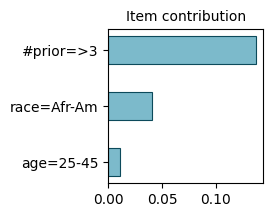

In [16]:
# We can also plot the Shapley value.

processor.plot_shapley_value(pattern = pattern, figsize=(2,2), title="Item contribution")

### Redundancy pruning

Sometimes, many similar patterns are returned: if $(A, B, C)$ is divergent, often so is $(A, B, C, D)$, $(A, B, C, E)$, and so on.
To obtain a more concise summary, we can prune patterns that are redundant, that is, too similar to other patterns.  
This prunes a pattern $\beta$ if there is a pattern $\alpha$, subset of $\beta$, with a divergence difference below a threshold. 

In [17]:
df_pruned = processor.redundancy_pruning(th_redundancy=0.01)
df_pruned.sort_values("fp_div", ascending=False).head(5)

,support,itemset,length,support_count,fp,fp_div,fp_t
0,0.122813,"(#prior=>3, race=Afr-Am, age=25-45)",3,758,0.276316,0.188002,13.683395
1,0.196695,"(#prior=>3, race=Afr-Am)",2,1214,0.261097,0.172783,15.525674
2,0.207226,"(#prior=>3, age=25-45)",2,1279,0.251889,0.163575,16.267585
3,0.146792,"(#prior=>3, sex=Male, race=Afr-Am)",3,906,0.241877,0.153563,14.424100
4,0.153597,"(#prior=>3, sex=Male, age=25-45)",3,948,0.234694,0.146380,14.387448


### Global Shapley value

We can compute the global shapley value of the pattern divergence across all the patterns.
This is helpful in understanding which attributes contribute most to the divergence, across all patterns.


In [18]:
gsv = processor.global_shapley_value()
gsv

{frozenset({'#prior=>3'}): np.float64(0.0178195842307307),
 frozenset({'age=<25'}): np.float64(0.009659973804123173),
 frozenset({'race=Afr-Am'}): np.float64(0.011190872219056293),
 frozenset({'sex=Male'}): np.float64(0.0012417066931630896),
 frozenset({'age=25-45'}): np.float64(6.0814974633318066e-05),
 frozenset({'#prior=[1,3]'}): np.float64(-0.0027715521320987304),
 frozenset({'sex=Female'}): np.float64(-0.0027027717590977353),
 frozenset({'#prior=0'}): np.float64(-0.005648272853174315),
 frozenset({'race=Cauc'}): np.float64(-0.007908050080949476),
 frozenset({'age=>45'}): np.float64(-0.006468567991314258)}

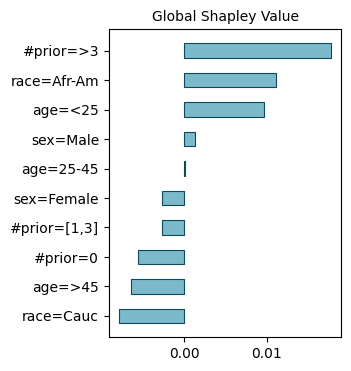

In [19]:
processor.plot_shapley_value(shapley_values=gsv, figsize=(3,4), title='Global Shapley Value')

We see how the main factor increasing false-positives, across all patterns (in combination with all other attributes) is a high number of priors, while the main factor reducing the false-positive rate is Caucasian race. 